In [3]:
import numpy as np
import pandas as pd
import jittor as jt
import os
from os.path import join, getsize

from jittor.dataset import Dataset
from PIL import Image
from dataset import Tiny_vid
import matplotlib.pyplot as plt



In [4]:
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

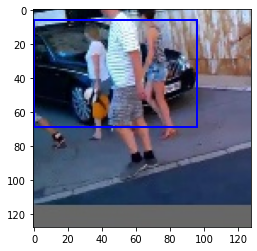

In [19]:
dataset = Tiny_vid().set_attrs(batch_size=1, shuffle=True)

for x, y in dataset:
    # plt.figure(0)
    ax = plt.imshow(x.squeeze(0))
    test_bbox = np.floor(y[1]*128)
    test_bbox = test_bbox.squeeze(0).tolist()
    # import pdb; pdb.set_trace()
    ax.axes.add_patch(bbox_to_rect(test_bbox, 'blue'))
    # print(x,y)
    break

AttributeError: 'jittor_core.Var' object has no attribute 'step'